# 1. Environment

Welcome to JAXMAN! In this tutorial we introduce how to create gym Environment and basic dynamics.

In JAXMAN, you can create and interact with three different environments, `Grid`, `Diff Drive`, and `Continuous`, from a common interface. We will now introduce each environment.

# Grid

First I will introduce the `Grid` environment. Along with the introduction of the `Grid`, I will also give an introduction to the basic JAXMAN interface.

A `Grid` is an environment with a discrete action space in which agents can move to adjacent cells. There are five types of agent actions: `UP`, `DOWN`, `RIGHT`, `LEFT`, and `STAY`. The environment is initialized using configuration, in which the environment settings are registered.

First, load the default configuration, then change the configuration to values consistent with the environment you wish to create. In this example, the `level` (number of obstacles) is set to 5, the `map_size` (size of map) to 20, and the `num_agents` (number of agents) to 3.

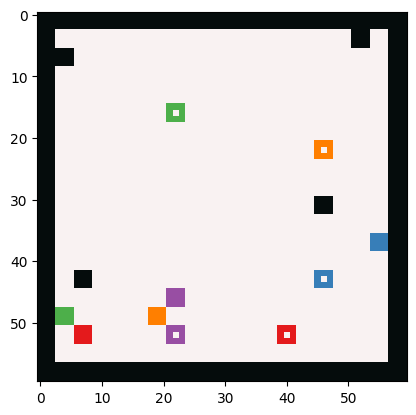

In [1]:
import hydra
import jax.numpy as jnp
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from jaxman.env.navigation.env import JaxMANEnv

from jaxman.utils import compute_agent_action

config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/env/navigation/grid.yaml"))
config.level=5
config.map_size=20
config.num_agents=5
env = JaxMANEnv(config)
env.reset()
plt.imshow(env.render())

Information about the agent's initial position, goal and obstacle positions is stored in `env.trial_info`.

You can set any initial position and goal you like at the time of reset. If you do not give `task_info` as a trigger for the reset function, the initial position and goal will be sampled randomly.

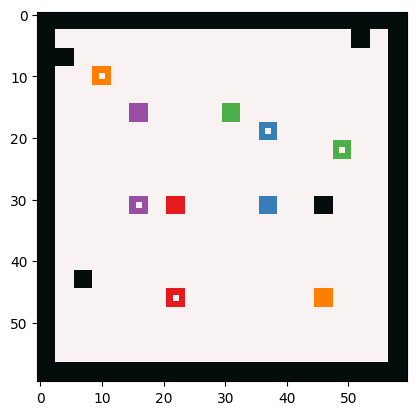

In [2]:
task_info = env.task_info._replace(starts = jnp.array([[7,10],[12,10],[10,5],[5,5],[15,15]]), 
                                   goals = jnp.array([[7,15],[12,6],[16,7],[5,10],[3,3]]))
env.reset(task_info=task_info)
plt.imshow(env.render())

JAXMAN has the same structure as the general GYM env step function. However, since JAXMAN assumes a multi-agent environment, the behavior has the same dimension as the number of agents.
As shown in the example below, agents move to the specified location by their actions.

The `reward` is composed of the following three elements
- `time_penalty` (-0.1): apply in every time step. `time_penalty` motivate agent to reach its goal as soon as possible
- `crash_penalty` (-10): apply when agent collided with agent or obstacles. `crash_penalty` motivate agent to avoid collision
- `goal_reward` (+10): apply when agent readh its goal. `goal_reward` motivate agent to reash its goal

The `done` is given to each agent independently. Each agent ends the episode when one of the following three conditions is satisfied
- `success`: agent reach its goal
- `crash`: agent collide with other agents or obstacles
- `timeout`: agent could not reach its goal by predefine episode max steps `T`

As in the example below, No further rewards are given to agents whose episodes have come to an end. Also, the terminated agent is forced to stand still even if an action is entered.

0
reward: [-0.1 -0.1 -0.1 -0.1 -0.1]
done: [False False False False False]
1
reward: [-0.1 -0.1 -0.1 -0.1 -0.1]
done: [False False False False False]
2
reward: [ -0.1 -10.1  -0.1  -0.1  -0.1]
done: [False  True False False False]
3
reward: [-0.1  0.  -0.1 -0.1 -0.1]
done: [False  True False False False]
4
reward: [ -0.1   0.  -10.1   2.9  -0.1]
done: [False  True  True  True False]


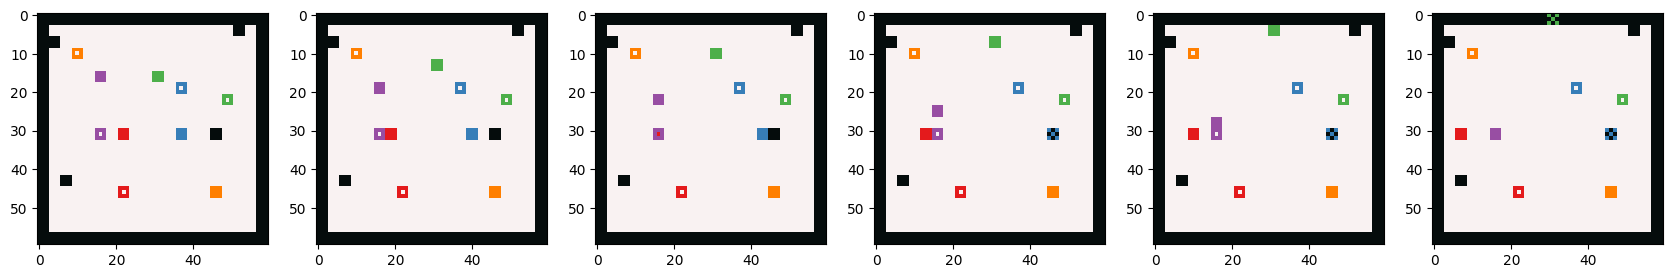

In [3]:
fig, axes = plt.subplots(1, 6, figsize=(21, 3))
axes[0].imshow(env.render())
action = ["LEFT","RIGHT","UP","DOWN", "STAY"]
action = compute_agent_action(action)
for i in range(5):
    obs, rew, done, trial_info = env.step(action)
    state = obs.state
    axes[i+1].imshow(env.render())
    print(i)
    print(f"reward: {rew}")
    print(f"done: {done}")

### agent observation

At each time step, the agent obtains an observation, which consists of the following six elements
- `pos`: agent current position
- `rot`: agent current rotation used for `Diff Drive` and `Continuous`
- `vel`: agent current velocity used for `Continuous`
- `ang`: agent current angular velocity used for `Continuous`
- `goal`: agent goal position
- `scan`: observe neighbor agent and obstacle position. In Discrete action Environment, agent can observe a limited field of view(FOV) centered around its poistion. FOV size is defined by `fov_r*2+1`

pos [6 5]
rot [0]
vel [0]
ang [0]
goal [6 5]
scan


Text(0.5, 1.0, 'Red agent field of view')

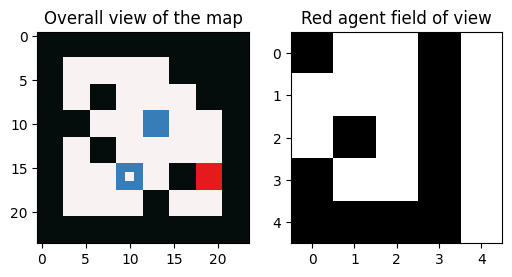

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
config.level=15
config.map_size=8
config.num_agents=2
config.fov_r=2
env = JaxMANEnv(config)
obs = env.reset()
axes[0].imshow(env.render())
axes[0].set_title("Overall view of the map")
print("pos", obs.state.pos[0])
print("rot", obs.state.rot[0])
print("vel", obs.state.vel[0])
print("ang", obs.state.ang[0])
print("goal", obs.goals[0])
print("scan")
axes[1].imshow(1-obs.scans[0].reshape(config.fov_r*2+1, config.fov_r*2+1).T, cmap="gray")
axes[1].set_title("Red agent field of view")

# Continuous Action Space

JAXMAN also supports continuous action spaces. 

You can generate an environment with continuous action space by setting `config.is_discrete` to `False`.

In [17]:
config = hydra.utils.instantiate(OmegaConf.load("../scripts/config/env/navigation/continuous.yaml"))
config.num_agents=4
env = JaxMANEnv(config, 46)
obs = env.reset()

In `continuous` the basic interface is the same as in an environment with a discrete action space. However, `continuous` differs from a discrete action space in the following two respects.

- The agent's output is defined by **acceleration**, not velocity. Therefore, the agent needs to plan its actions considering its current own `vel` and `ang`.
- Agents obtain the positions of nearby agents and obstacles by **lidar observation**.
- The agent is observed as observing the output of the **classical planner (DWA)**. This is defined as the `planner_act` property of `obs`, which can be used to control the agent.

In the example below, the environment is given `obs.planner_act` as action. It is clear from the example below that when the number of agents is small, it is possible to navigate by using the classical planner action, but when the number of agents and obstacles increases and the problem becomes more difficult, the classical planner fails to solve the problem It can be seen that the classical planner fails to solve the problem.

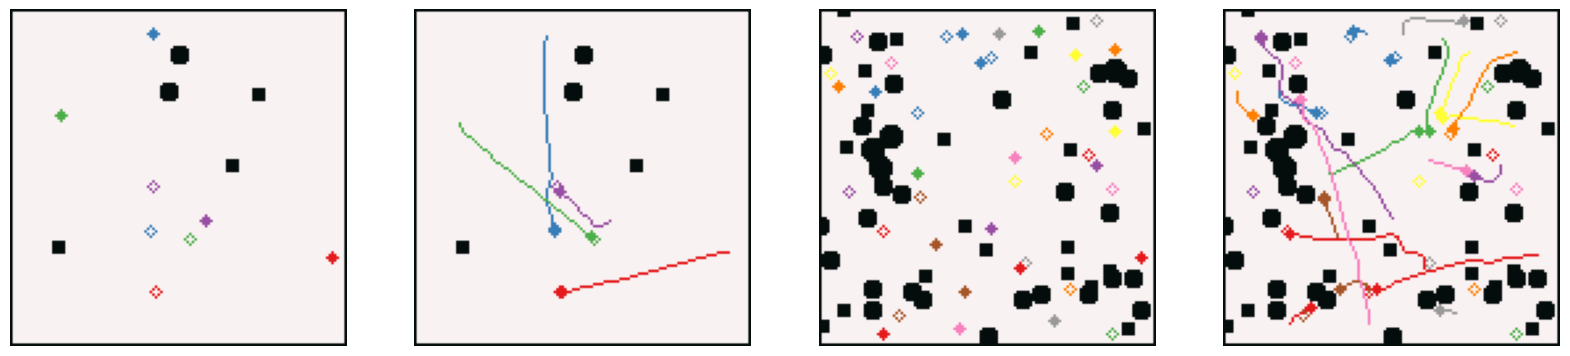

In [18]:
# Easy Task
config.num_agents=4
config.level=5
env = JaxMANEnv(config, 46)
obs = env.reset()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
[axi.set_axis_off() for axi in axes.ravel()]
axes[0].imshow(env.render())

state_traj = []
done = False
while not done:
    action = obs.planner_act
    obs, rew, done, trial_info = env.step(action)
    state_traj.append(obs.state.cat())
    done = jnp.all(done)
    # print(action)
state_traj = jnp.array(state_traj)
axes[1].imshow(env.render(state_traj = state_traj))

# Hard Task
config.num_agents=20
config.level=50
env = JaxMANEnv(config, 46)
obs = env.reset()
axes[2].imshow(env.render())
state_traj = []
done = False
while not done:
    action = obs.planner_act
    obs, rew, done, trial_info = env.step(action)
    state_traj.append(obs.state.cat())
    done = jnp.all(done)
state_traj = jnp.array(state_traj)
axes[3].imshow(env.render(state_traj = state_traj))


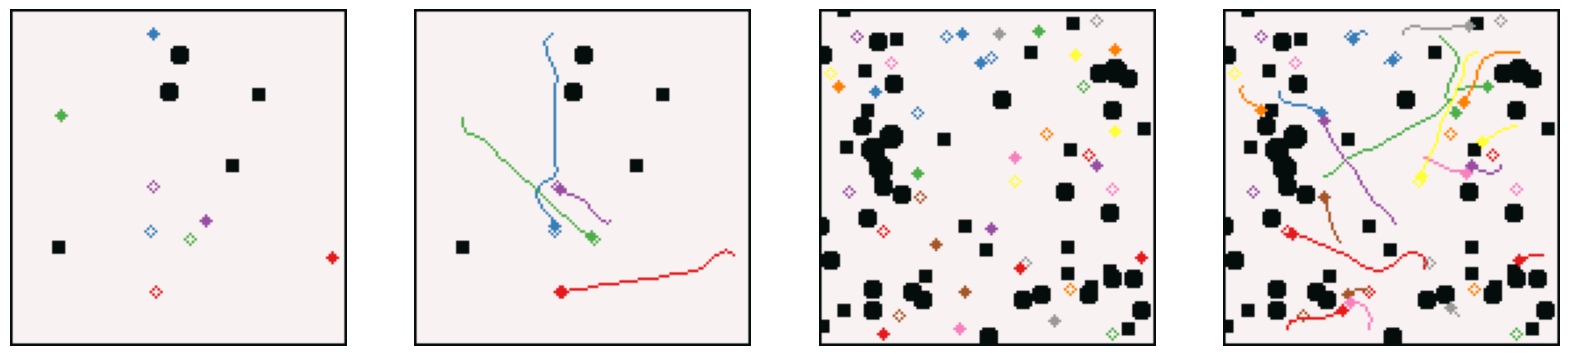

In [16]:
# acceralation based environment
# Easy Task
config.num_agents=4
config.level=5
config.use_acc=True
env = JaxMANEnv(config, 46)
obs = env.reset()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
[axi.set_axis_off() for axi in axes.ravel()]
axes[0].imshow(env.render())

state_traj = []
done = False
while not done:
    action = obs.planner_act
    obs, rew, done, trial_info = env.step(action)
    state_traj.append(obs.state.cat())
    done = jnp.all(done)
    # print(action)
state_traj = jnp.array(state_traj)
axes[1].imshow(env.render(state_traj = state_traj))

# Hard Task
config.num_agents=20
config.level=50
config.use_acc=True
env = JaxMANEnv(config, 46)
obs = env.reset()
axes[2].imshow(env.render())
state_traj = []
done = False
while not done:
    action = obs.planner_act
    obs, rew, done, trial_info = env.step(action)
    state_traj.append(obs.state.cat())
    done = jnp.all(done)
state_traj = jnp.array(state_traj)
axes[3].imshow(env.render(state_traj = state_traj))
